In [16]:
# Cell 1: Custom MLMD Store Implementation

import sqlite3
import json
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

class MLMetadataStore:
    """Custom MLMD-like store using SQLite"""
    
    def __init__(self, db_path='./mlmd_iris.db'):
        self.db_path = db_path
        self.conn = sqlite3.connect(db_path)
        self._create_tables()
        
    def _create_tables(self):
        """Create MLMD-like tables"""
        cursor = self.conn.cursor()
        
        # Artifact table (datasets, models, metrics)
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS artifacts (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                type TEXT NOT NULL,
                name TEXT NOT NULL,
                uri TEXT,
                properties TEXT,
                created_at TEXT
            )
        ''')
        
        # Execution table (training runs, evaluations)
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS executions (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                type TEXT NOT NULL,
                name TEXT NOT NULL,
                state TEXT,
                properties TEXT,
                created_at TEXT
            )
        ''')
        
        # Events table (links artifacts to executions)
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS events (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                artifact_id INTEGER,
                execution_id INTEGER,
                type TEXT,
                created_at TEXT,
                FOREIGN KEY (artifact_id) REFERENCES artifacts(id),
                FOREIGN KEY (execution_id) REFERENCES executions(id)
            )
        ''')
        
        # Context table (pipeline runs)
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS contexts (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                type TEXT NOT NULL,
                name TEXT NOT NULL,
                properties TEXT,
                created_at TEXT
            )
        ''')
        
        self.conn.commit()
        
    def create_artifact(self, artifact_type, name, uri=None, properties=None):
        """Create an artifact (dataset, model, metrics)"""
        cursor = self.conn.cursor()
        cursor.execute('''
            INSERT INTO artifacts (type, name, uri, properties, created_at)
            VALUES (?, ?, ?, ?, ?)
        ''', (artifact_type, name, uri, json.dumps(properties or {}), datetime.now().isoformat()))
        self.conn.commit()
        return cursor.lastrowid
    
    def create_execution(self, exec_type, name, state='COMPLETE', properties=None):
        """Create an execution (training, evaluation)"""
        cursor = self.conn.cursor()
        cursor.execute('''
            INSERT INTO executions (type, name, state, properties, created_at)
            VALUES (?, ?, ?, ?, ?)
        ''', (exec_type, name, state, json.dumps(properties or {}), datetime.now().isoformat()))
        self.conn.commit()
        return cursor.lastrowid
    
    def create_event(self, artifact_id, execution_id, event_type):
        """Link artifact to execution"""
        cursor = self.conn.cursor()
        cursor.execute('''
            INSERT INTO events (artifact_id, execution_id, type, created_at)
            VALUES (?, ?, ?, ?)
        ''', (artifact_id, execution_id, event_type, datetime.now().isoformat()))
        self.conn.commit()
        return cursor.lastrowid
    
    def create_context(self, context_type, name, properties=None):
        """Create a context (pipeline run)"""
        cursor = self.conn.cursor()
        cursor.execute('''
            INSERT INTO contexts (type, name, properties, created_at)
            VALUES (?, ?, ?, ?)
        ''', (context_type, name, json.dumps(properties or {}), datetime.now().isoformat()))
        self.conn.commit()
        return cursor.lastrowid
    
    def get_artifacts(self):
        """Retrieve all artifacts"""
        cursor = self.conn.cursor()
        cursor.execute('SELECT * FROM artifacts')
        return cursor.fetchall()
    
    def get_executions(self):
        """Retrieve all executions"""
        cursor = self.conn.cursor()
        cursor.execute('SELECT * FROM executions')
        return cursor.fetchall()
    
    def get_lineage(self, artifact_id):
        """Get lineage for an artifact"""
        cursor = self.conn.cursor()
        cursor.execute('''
            SELECT e.*, ex.type, ex.name, ev.type as event_type
            FROM events e
            JOIN executions ex ON e.execution_id = ex.id
            WHERE e.artifact_id = ?
        ''', (artifact_id,))
        return cursor.fetchall()
    
    def close(self):
        """Close database connection"""
        self.conn.close()

# Initialize the store
store = MLMetadataStore('./mlmd_iris.db')

print("✅ Custom MLMD Store initialized successfully!")
print(f"📁 Database location: ./mlmd_iris.db")
print(f"📊 Tables created: artifacts, executions, events, contexts")


✅ Custom MLMD Store initialized successfully!
📁 Database location: ./mlmd_iris.db
📊 Tables created: artifacts, executions, events, contexts


In [17]:
from datetime import datetime

# Create a context for this pipeline run
context_id = store.create_context(
    context_type="IrisClassificationPipeline",
    name=f"iris_pipeline_run_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
    properties={
        "pipeline_name": "Iris Classification",
        "run_date": datetime.now().isoformat(),
        "author": "Krishna",
        "description": "Training RandomForest classifier on Iris dataset"
    }
)

print("✅ Pipeline Context Created!")
print(f"   Context ID: {context_id}")
print(f"   Context Type: IrisClassificationPipeline")
print(f"   Run Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Pipeline Context Created!
   Context ID: 1
   Context Type: IrisClassificationPipeline
   Run Date: 2025-11-04 13:28:08


📊 Iris Dataset Loaded
   Total samples: 150
   Features: 4
   Classes: 3

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target target_name  
0       0      setosa  
1       0      setosa  
2       0      setosa  
3       0      setosa  
4       0      setosa  

✅ Dataset Artifact Created!
   Artifact ID: 1
   Execution ID: 2
   Event: Dataset OUTPUT from DataIngestion


/var/folders/kz/2m26_l2x33gbx86mj66vhv_h0000gn/T/ipykernel_83352/4014290450.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([feature_data[col] for col in feature_data.columns],


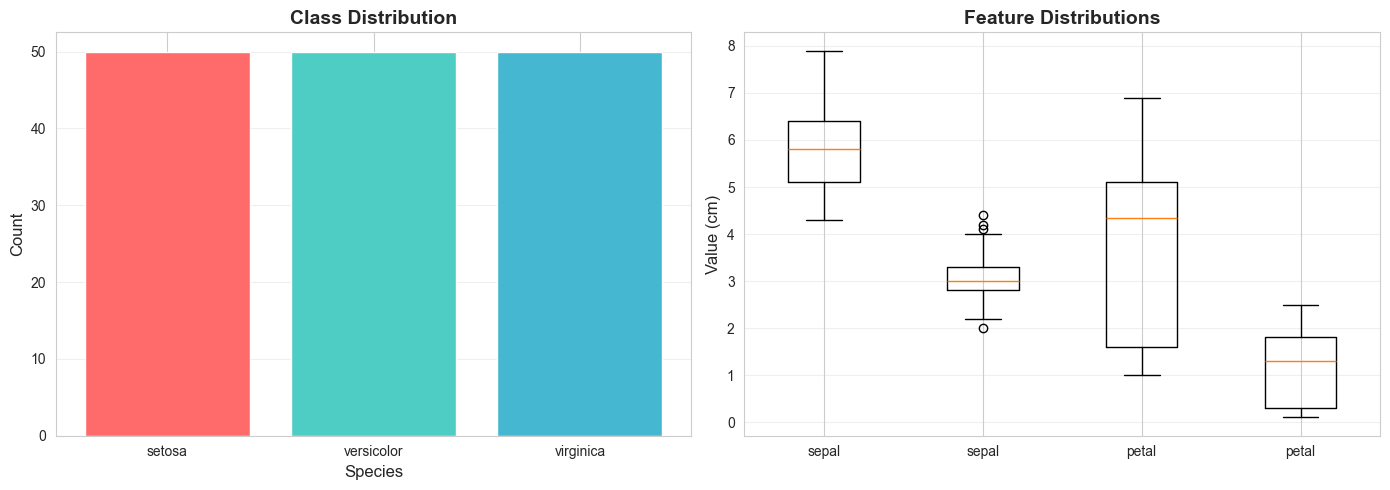


📈 Visualizations: Class distribution and feature distributions


In [19]:
# Cell 3: Load Iris Dataset and Register as Artifact

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Create DataFrame for better visualization
iris_df = pd.DataFrame(X, columns=iris.feature_names)
iris_df['target'] = y
iris_df['target_name'] = iris_df['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

print("📊 Iris Dataset Loaded")
print(f"   Total samples: {len(iris_df)}")
print(f"   Features: {len(iris.feature_names)}")
print(f"   Classes: {len(iris.target_names)}")
print(f"\n{iris_df.head()}")

# Create execution for data ingestion
data_ingestion_exec_id = store.create_execution(
    exec_type="DataIngestion",
    name="load_iris_dataset",
    state="COMPLETE",
    properties={
        "dataset_name": "Iris",
        "source": "sklearn.datasets",
        "n_samples": int(len(iris_df)),
        "n_features": int(len(iris.feature_names)),
        "n_classes": int(len(iris.target_names))
    }
)

# Create dataset artifact
dataset_artifact_id = store.create_artifact(
    artifact_type="Dataset",
    name="iris_dataset",
    uri="sklearn://datasets/iris",
    properties={
        "n_samples": int(len(iris_df)),
        "n_features": int(len(iris.feature_names)),
        "feature_names": list(iris.feature_names),
        "target_names": list(iris.target_names),
        "class_distribution": {int(k): int(v) for k, v in iris_df['target'].value_counts().to_dict().items()}
    }
)

# Link artifact to execution (OUTPUT event)
store.create_event(dataset_artifact_id, data_ingestion_exec_id, "OUTPUT")

print(f"\n✅ Dataset Artifact Created!")
print(f"   Artifact ID: {dataset_artifact_id}")
print(f"   Execution ID: {data_ingestion_exec_id}")
print(f"   Event: Dataset OUTPUT from DataIngestion")

# Visualize dataset
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Class distribution
class_counts = iris_df['target_name'].value_counts()
axes[0].bar(class_counts.index, class_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Species', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Feature distributions (boxplot)
feature_data = iris_df[iris.feature_names]
axes[1].boxplot([feature_data[col] for col in feature_data.columns], 
                labels=[col.split(' ')[0] for col in feature_data.columns])
axes[1].set_title('Feature Distributions', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Value (cm)', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 Visualizations: Class distribution and feature distributions")

📊 Dataset Split
   Training samples: 105
   Testing samples: 45
   Train/Test ratio: 70/30

🤖 Model Training Complete
   Algorithm: RandomForestClassifier
   N_estimators: 100
   Max_depth: 5

✅ Model Artifact Created!
   Model Artifact ID: 2
   Training Execution ID: 3
   Lineage: Dataset → Training → Model


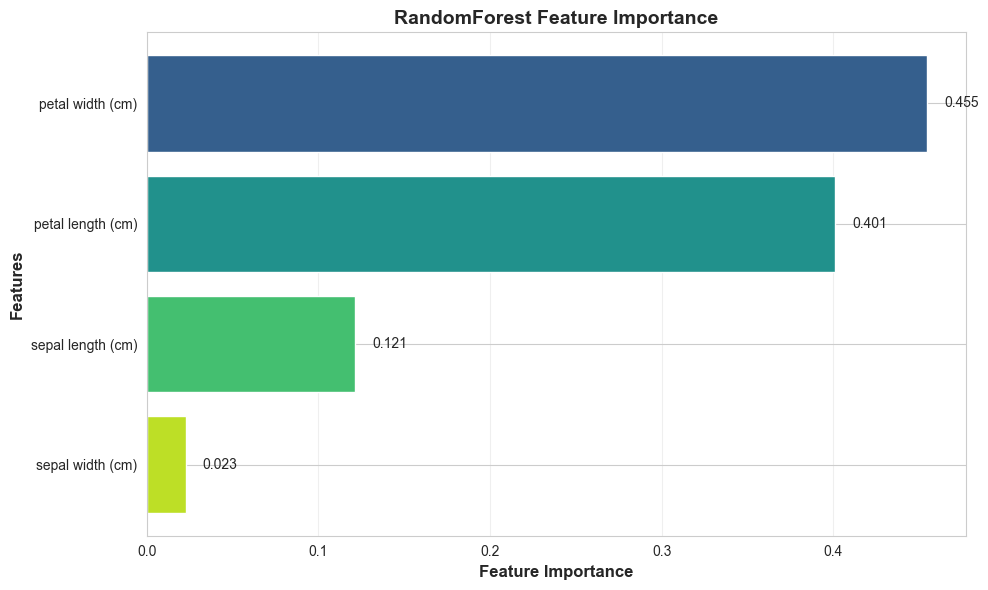


📊 Feature Importance Visualization Complete

Top Feature: petal width (cm) (0.455)


In [20]:
# Cell 4: Train RandomForest Model and Register Artifacts

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("📊 Dataset Split")
print(f"   Training samples: {len(X_train)}")
print(f"   Testing samples: {len(X_test)}")
print(f"   Train/Test ratio: 70/30")

# Train RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
model.fit(X_train, y_train)

print(f"\n🤖 Model Training Complete")
print(f"   Algorithm: RandomForestClassifier")
print(f"   N_estimators: 100")
print(f"   Max_depth: 5")

# Create training execution
training_exec_id = store.create_execution(
    exec_type="ModelTraining",
    name="train_random_forest",
    state="COMPLETE",
    properties={
        "algorithm": "RandomForestClassifier",
        "n_estimators": 100,
        "max_depth": 5,
        "random_state": 42,
        "train_samples": int(len(X_train)),
        "test_samples": int(len(X_test)),
        "test_size": 0.3
    }
)

# Create model artifact
model_artifact_id = store.create_artifact(
    artifact_type="Model",
    name="iris_random_forest_model",
    uri="models://iris_rf_v1",
    properties={
        "algorithm": "RandomForestClassifier",
        "n_estimators": 100,
        "max_depth": 5,
        "n_features": int(X_train.shape[1]),
        "n_classes": int(len(np.unique(y)))
    }
)

# Link dataset as INPUT to training
store.create_event(dataset_artifact_id, training_exec_id, "INPUT")

# Link model as OUTPUT from training
store.create_event(model_artifact_id, training_exec_id, "OUTPUT")

print(f"\n✅ Model Artifact Created!")
print(f"   Model Artifact ID: {model_artifact_id}")
print(f"   Training Execution ID: {training_exec_id}")
print(f"   Lineage: Dataset → Training → Model")

# Visualize feature importance
feature_importance = pd.DataFrame({
    'feature': iris.feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_importance)))
bars = plt.barh(feature_importance['feature'], feature_importance['importance'], color=colors)
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('RandomForest Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, feature_importance['importance'])):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n📊 Feature Importance Visualization Complete")
print(f"\nTop Feature: {feature_importance.iloc[0]['feature']} ({feature_importance.iloc[0]['importance']:.3f})")

📊 Model Evaluation Results
   Accuracy:  0.8889
   Precision: 0.8981
   Recall:    0.8889
   F1-Score:  0.8878

✅ Metrics Artifact Created!
   Metrics Artifact ID: 3
   Evaluation Execution ID: 4
   Lineage: Model → Evaluation → Metrics


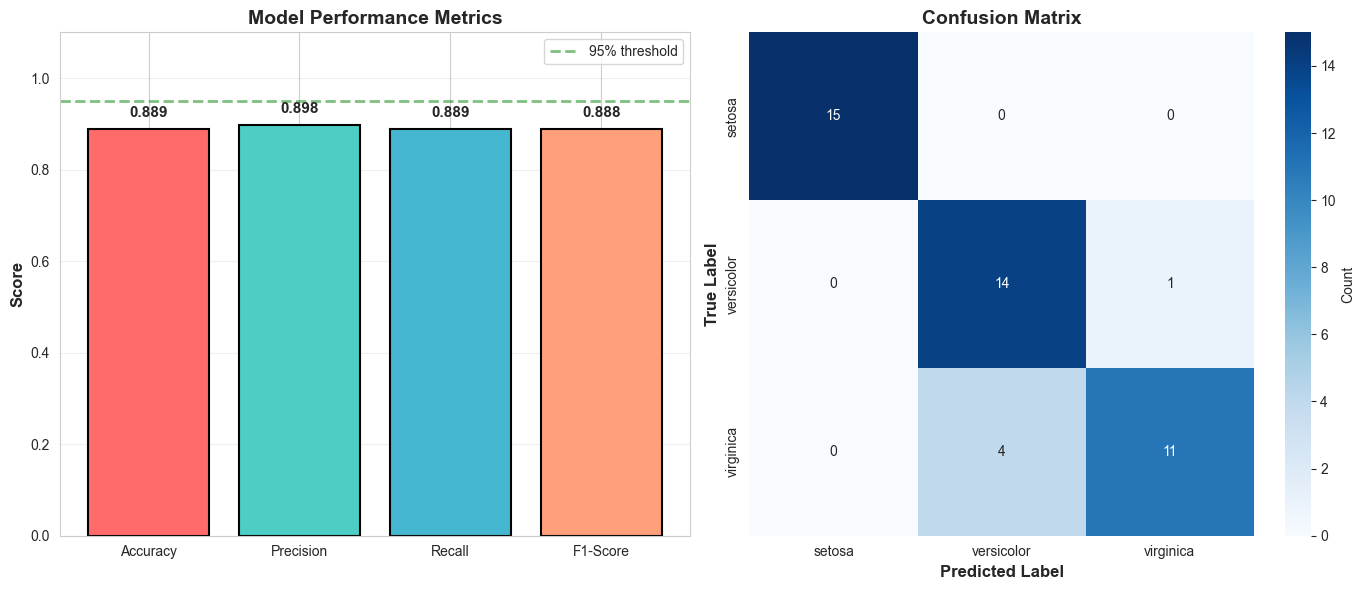


📈 Visualizations: Performance metrics and confusion matrix

📊 Per-Class Performance:
   setosa      : 1.0000
   versicolor  : 0.9333
   virginica   : 0.7333


In [21]:
# Cell 5: Evaluate Model and Register Metrics Artifact

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("📊 Model Evaluation Results")
print(f"   Accuracy:  {accuracy:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")

# Create evaluation execution
evaluation_exec_id = store.create_execution(
    exec_type="ModelEvaluation",
    name="evaluate_random_forest",
    state="COMPLETE",
    properties={
        "test_samples": int(len(X_test)),
        "evaluation_date": datetime.now().isoformat()
    }
)

# Create metrics artifact
metrics_artifact_id = store.create_artifact(
    artifact_type="Metrics",
    name="iris_model_metrics",
    uri="metrics://iris_rf_v1",
    properties={
        "accuracy": float(accuracy),
        "precision": float(precision),
        "recall": float(recall),
        "f1_score": float(f1),
        "test_samples": int(len(X_test))
    }
)

# Link model as INPUT to evaluation
store.create_event(model_artifact_id, evaluation_exec_id, "INPUT")

# Link metrics as OUTPUT from evaluation
store.create_event(metrics_artifact_id, evaluation_exec_id, "OUTPUT")

print(f"\n✅ Metrics Artifact Created!")
print(f"   Metrics Artifact ID: {metrics_artifact_id}")
print(f"   Evaluation Execution ID: {evaluation_exec_id}")
print(f"   Lineage: Model → Evaluation → Metrics")

# Visualization 1: Metrics Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

metrics_dict = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
bars = axes[0].bar(metrics_dict.keys(), metrics_dict.values(), color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylim(0, 1.1)
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].axhline(y=0.95, color='green', linestyle='--', linewidth=2, alpha=0.5, label='95% threshold')
axes[0].legend()

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Visualization 2: Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=iris.target_names, 
            yticklabels=iris.target_names,
            cbar_kws={'label': 'Count'},
            ax=axes[1])
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📈 Visualizations: Performance metrics and confusion matrix")

# Per-class performance
print("\n📊 Per-Class Performance:")
for i, class_name in enumerate(iris.target_names):
    class_mask = (y_test == i)
    class_accuracy = accuracy_score(y_test[class_mask], y_pred[class_mask])
    print(f"   {class_name:12s}: {class_accuracy:.4f}")

In [23]:
# Cell 6: Query MLMD Store and Verify Lineage

# First, fix the get_lineage method
def get_lineage_fixed(self, artifact_id):
    """Get lineage for an artifact"""
    cursor = self.conn.cursor()
    cursor.execute('''
        SELECT e.*, ex.type, ex.name, e.type as event_type
        FROM events e
        JOIN executions ex ON e.execution_id = ex.id
        WHERE e.artifact_id = ?
    ''', (artifact_id,))
    return cursor.fetchall()

# Apply the fix
store.get_lineage = lambda artifact_id: get_lineage_fixed(store, artifact_id)

print("=" * 70)
print("📚 QUERYING ML METADATA STORE")
print("=" * 70)

# Query all artifacts
print("\n1️⃣  ALL ARTIFACTS")
print("-" * 70)
artifacts = store.get_artifacts()
artifacts_df = pd.DataFrame(artifacts, columns=['ID', 'Type', 'Name', 'URI', 'Properties', 'Created_At'])
print(artifacts_df.to_string(index=False))

# Query all executions
print("\n\n2️⃣  ALL EXECUTIONS")
print("-" * 70)
executions = store.get_executions()
executions_df = pd.DataFrame(executions, columns=['ID', 'Type', 'Name', 'State', 'Properties', 'Created_At'])
print(executions_df.to_string(index=False))

# Query lineage for model artifact
print("\n\n3️⃣  LINEAGE FOR MODEL ARTIFACT (ID: {})".format(model_artifact_id))
print("-" * 70)
model_lineage = store.get_lineage(model_artifact_id)
if model_lineage:
    print(f"Found {len(model_lineage)} related executions:")
    for lin in model_lineage:
        print(f"   → Execution: {lin[5]} (Type: {lin[4]}, Event: {lin[6]})")
else:
    print("   No lineage found")

# Query lineage for metrics artifact
print("\n\n4️⃣  LINEAGE FOR METRICS ARTIFACT (ID: {})".format(metrics_artifact_id))
print("-" * 70)
metrics_lineage = store.get_lineage(metrics_artifact_id)
if metrics_lineage:
    print(f"Found {len(metrics_lineage)} related executions:")
    for lin in metrics_lineage:
        print(f"   → Execution: {lin[5]} (Type: {lin[4]}, Event: {lin[6]})")
else:
    print("   No lineage found")

# Get detailed artifact properties
print("\n\n5️⃣  DETAILED ARTIFACT PROPERTIES")
print("-" * 70)

cursor = store.conn.cursor()
for artifact_id, artifact_name in [(dataset_artifact_id, "Dataset"), 
                                     (model_artifact_id, "Model"), 
                                     (metrics_artifact_id, "Metrics")]:
    cursor.execute('SELECT properties FROM artifacts WHERE id = ?', (artifact_id,))
    props = json.loads(cursor.fetchone()[0])
    print(f"\n{artifact_name} (ID: {artifact_id}):")
    for key, value in props.items():
        print(f"   • {key}: {value}")

# Visualize complete pipeline lineage
print("\n\n6️⃣  COMPLETE PIPELINE LINEAGE")
print("-" * 70)
print("""
    ┌─────────────────┐
    │ Data Ingestion  │  (Execution ID: {})
    └────────┬────────┘
             │ OUTPUT
             ▼
    ┌─────────────────┐
    │   Iris Dataset  │  (Artifact ID: {})
    └────────┬────────┘
             │ INPUT
             ▼
    ┌─────────────────┐
    │ Model Training  │  (Execution ID: {})
    └────────┬────────┘
             │ OUTPUT
             ▼
    ┌─────────────────┐
    │  Trained Model  │  (Artifact ID: {})
    └────────┬────────┘
             │ INPUT
             ▼
    ┌─────────────────┐
    │   Evaluation    │  (Execution ID: {})
    └────────┬────────┘
             │ OUTPUT
             ▼
    ┌─────────────────┐
    │     Metrics     │  (Artifact ID: {})
    └─────────────────┘
""".format(data_ingestion_exec_id, dataset_artifact_id, 
           training_exec_id, model_artifact_id, evaluation_exec_id, metrics_artifact_id))

print("\n✅ Metadata Query Complete!")
print("=" * 70)

📚 QUERYING ML METADATA STORE

1️⃣  ALL ARTIFACTS
----------------------------------------------------------------------
 ID    Type                     Name                     URI                                                                                                                                                                                                                                         Properties                 Created_At
  1 Dataset             iris_dataset sklearn://datasets/iris {"n_samples": 150, "n_features": 4, "feature_names": ["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"], "target_names": ["setosa", "versicolor", "virginica"], "class_distribution": {"0": 50, "1": 50, "2": 50}} 2025-11-04T13:29:46.125506
  2   Model iris_random_forest_model     models://iris_rf_v1                                                                                                                                      {"algorithm": "RandomFor

🎯 LAB SUMMARY

📊 MLMD Store Contents:
   • Artifacts:  3
   • Executions: 4
   • Events:     5

🤖 Model Performance:
   • Accuracy:  88.89%
   • Precision: 89.81%
   • Recall:    88.89%
   • F1-Score:  88.78%

📁 Database Location: ./mlmd_iris.db

🔗 Pipeline Lineage:

    Data Ingestion (Execution)
            ↓
    Iris Dataset (Artifact)
            ↓
    Model Training (Execution)
            ↓
    Trained Model (Artifact)
            ↓
    Evaluation (Execution)
            ↓
    Metrics (Artifact)



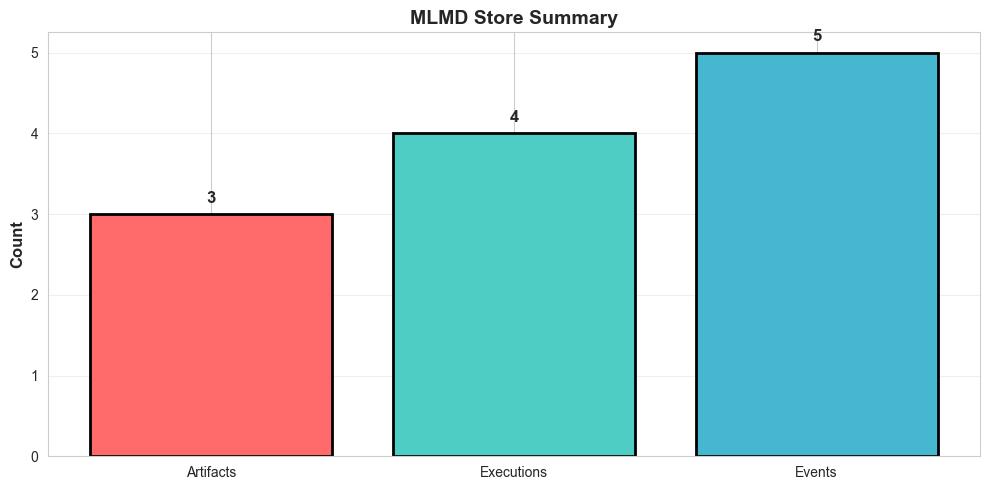


✅ LAB COMPLETED SUCCESSFULLY!


In [25]:
# Cell 7: Simple Summary and Visualization

print("=" * 70)
print("🎯 LAB SUMMARY")
print("=" * 70)

# Count all entities
cursor = store.conn.cursor()
cursor.execute('SELECT COUNT(*) FROM artifacts')
total_artifacts = cursor.fetchone()[0]

cursor.execute('SELECT COUNT(*) FROM executions')
total_executions = cursor.fetchone()[0]

cursor.execute('SELECT COUNT(*) FROM events')
total_events = cursor.fetchone()[0]

print(f"\n📊 MLMD Store Contents:")
print(f"   • Artifacts:  {total_artifacts}")
print(f"   • Executions: {total_executions}")
print(f"   • Events:     {total_events}")

print(f"\n🤖 Model Performance:")
print(f"   • Accuracy:  {accuracy:.2%}")
print(f"   • Precision: {precision:.2%}")
print(f"   • Recall:    {recall:.2%}")
print(f"   • F1-Score:  {f1:.2%}")

print(f"\n📁 Database Location: ./mlmd_iris.db")

# Simple lineage visualization
print("\n🔗 Pipeline Lineage:")
print("""
    Data Ingestion (Execution)
            ↓
    Iris Dataset (Artifact)
            ↓
    Model Training (Execution)
            ↓
    Trained Model (Artifact)
            ↓
    Evaluation (Execution)
            ↓
    Metrics (Artifact)
""")

# Simple bar chart
fig, ax = plt.subplots(figsize=(10, 5))

categories = ['Artifacts', 'Executions', 'Events']
counts = [total_artifacts, total_executions, total_events]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = ax.bar(categories, counts, color=colors, edgecolor='black', linewidth=2)
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('MLMD Store Summary', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{int(height)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✅ LAB COMPLETED SUCCESSFULLY!")
print("=" * 70)
